<a href="https://colab.research.google.com/github/ivanlee1999/adversaryAttack/blob/master/foolbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load Mnist data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)

In [3]:
# ultra parameter
batch_size = 10
epoch = 1
learning_rate = 0.001


In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# load to cudo
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")


In [6]:
device

device(type='cuda')

In [7]:
# initialize network
simple_model = Net().to(device)
optimizer1 = torch.optim.SGD(simple_model.parameters(),lr = learning_rate,momentum=0.9)
print (simple_model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [16]:
# train model
def train(model,optimizer):
  for i in range(epoch):
    for j,(data,target) in tqdm(enumerate(train_loader)):
      data = data.to(device)
      target = target.to(device)
      logit = model(data)
      loss = F.nll_loss(logit,target)
      model.zero_grad()
      
      loss.backward()
      optimizer.step()
      # if j % 1000 == 0:
      #   print ('data{},loss{}'.format(j,loss))
train(simple_model,optimizer1)

6000it [00:16, 365.81it/s]


In [9]:
# eval eval
simple_model.eval()

# test data
def test(model,name):
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(test_loader)):
    data = data.to(device)
    target = target.to(device)
    logit = model(data)
    pred = logit.max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} correct rate is {}'.format(name,correct_num/10000))

test(simple_model,'simple model')

1000it [00:01, 620.87it/s]

tensor(9527, device='cuda:0')

simple model correct rate is 0.9526999592781067


In [10]:
!pip install foolbox

In [17]:
import foolbox as fb  
from foolbox.criteria import TargetedMisclassification

# here change to our model
fmodel = fb.PyTorchModel(simple_model,bounds=(0,1))
images, labels = fb.utils.samples(fmodel, dataset='mnist', batchsize=10)

print (images.shape)
print (labels.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [12]:
import time

# plot
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name):
  n_cols = 2
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(4*n_rows,2*n_cols))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      if j == 0:
        plt.ylabel(attack_name,size=15)
      plt.title("{} -> {}".format(clean_target[cnt-1], adver_target[cnt-1]))
      plt.imshow(clean_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()
  print ('\n')

In [13]:
# change to a specific label n
def CW_target(n):
  start = time.time()
  criterion = TargetedMisclassification(torch.tensor([n]*batch_size,device = device))
  attack = fb.attacks.L2CarliniWagnerAttack()
  raw, clipped, is_adv = attack(fmodel,images.to(device),epsilons=0.2,criterion = criterion)
  adver_target = torch.max(fmodel(raw),1)[1]
  plot_clean_and_adver(raw,adver_target,images,labels,'CW targeted')
  end = time.time()
  print ('CW target running {} seconds using google colab GPU'.format((end-start)))

In [14]:
# random attact to other model
def CW_untarget():
  start = time.time()
  attack = fb.attacks.L2CarliniWagnerAttack()
  raw, clipped, is_adv = attack(fmodel,images.to(device),labels.to(device),epsilons=0.2)
  adver_target = torch.max(fmodel(raw),1)[1]
  plot_clean_and_adver(raw,adver_target,images,labels,'CW untargeted')
  end = time.time()
  print ('CW untargeted running {} seconds using google colab GPU'.format((end-start)))

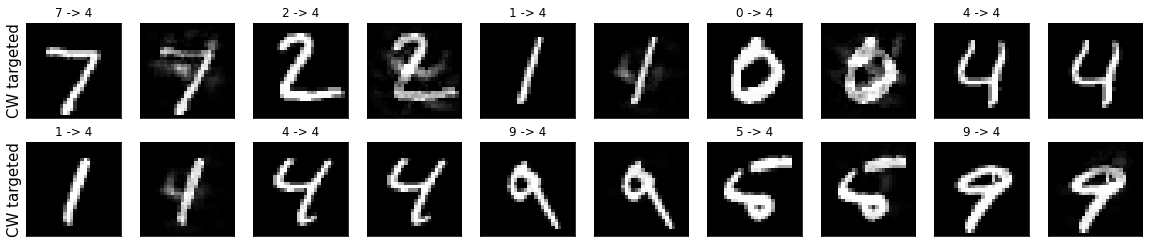



CW target running 105.43646669387817 seconds using google colab GPU


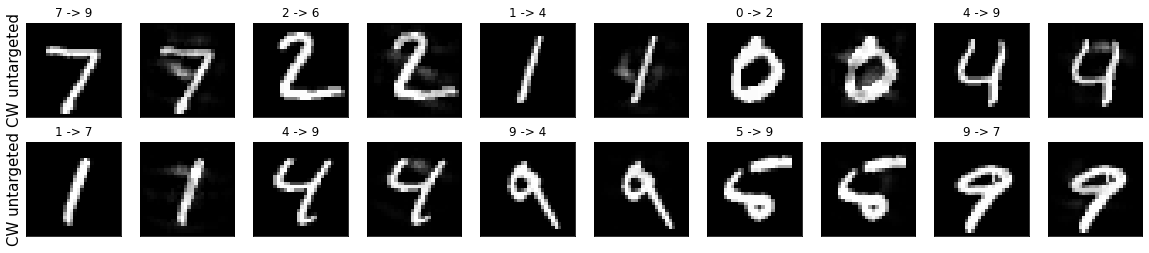



CW untargeted running 80.73789572715759 seconds using google colab GPU


In [15]:
CW_target(4)
CW_untarget()